# Experiment 1: Random 70-30 Split

Baseline experiment with stratified random split:
- 70% of labeled data for training
- 30% of labeled data for testing
- Stratified split maintains class distribution
- Uses class weights to handle imbalance (9.8% illicit vs 90.2% licit)

In [19]:
import pandas as pd
classes_df = pd.read_csv("raw_data/elliptic_bitcoin_dataset/elliptic_txs_classes.csv")
edgelist_df = pd.read_csv("raw_data/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv")
features_df = pd.read_csv("raw_data/elliptic_bitcoin_dataset/elliptic_txs_features.csv")

In [20]:
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, mean_squared_error
from sklearn.model_selection import train_test_split
import time

In [21]:
# Prepare node features
features = features_df.iloc[:, 1:].values
node_ids = features_df.iloc[:, 0].values

# Create node ID to index mapping
node_id_to_idx = {node_id: idx for idx, node_id in enumerate(node_ids)}

# Prepare labels - CORRECT MAPPING: '1'=illicit, '2'=licit
# Map to: 0=unknown, 1=illicit, 2=licit
classes_df['class'] = classes_df['class'].map({'unknown': 0, '1': 1, '2': 2})
labels = np.zeros(len(node_ids), dtype=int)
for _, row in classes_df.iterrows():
    if row['txId'] in node_id_to_idx:
        labels[node_id_to_idx[row['txId']]] = row['class']

# Prepare edge index
edge_list = []
for _, row in edgelist_df.iterrows():
    if row['txId1'] in node_id_to_idx and row['txId2'] in node_id_to_idx:
        edge_list.append([node_id_to_idx[row['txId1']], node_id_to_idx[row['txId2']]])

edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()

# Convert to PyTorch tensors
x = torch.tensor(features, dtype=torch.float)
y = torch.tensor(labels, dtype=torch.long)

print(f"Number of nodes: {x.shape[0]}")
print(f"Number of features: {x.shape[1]}")
print(f"Number of edges: {edge_index.shape[1]}")
print(f"Label distribution: Unknown={sum(y==0)}, Illicit={sum(y==1)}, Licit={sum(y==2)}")

Number of nodes: 203768
Number of features: 166
Number of edges: 234353
Label distribution: Unknown=157204, Illicit=4545, Licit=42019


In [22]:
# Create train/test split (only on labeled nodes)
labeled_mask = y > 0
labeled_indices = torch.where(labeled_mask)[0].numpy()

train_indices, test_indices = train_test_split(
    labeled_indices, 
    test_size=0.3, 
    random_state=42, 
    stratify=y[labeled_indices].numpy()
)

# Create masks
train_mask = torch.zeros(len(y), dtype=torch.bool)
test_mask = torch.zeros(len(y), dtype=torch.bool)
train_mask[train_indices] = True
test_mask[test_indices] = True

print(f"Training nodes: {train_mask.sum()}")
print(f"Test nodes: {test_mask.sum()}")
print(f"Unknown nodes: {(~labeled_mask).sum()}")

Training nodes: 32594
Test nodes: 13970
Unknown nodes: 157204


In [23]:
class GCNFraudDetector(torch.nn.Module):
    def __init__(self, in_features=166, hidden=64, out_classes=3, dropout=0.5):
        super().__init__()
        self.gcn1 = GCNConv(in_features, hidden)
        self.gcn2 = GCNConv(hidden, hidden // 2)
        self.fc = torch.nn.Linear(hidden // 2, out_classes)
        self.dropout = dropout
    
    def forward(self, x, edge_index):
        # GCN Layer 1
        x = self.gcn1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # GCN Layer 2
        x = self.gcn2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Output layer
        x = self.fc(x)
        return x

model = GCNFraudDetector(in_features=x.shape[1], hidden=64, out_classes=3, dropout=0.5)
print(model)

GCNFraudDetector(
  (gcn1): GCNConv(166, 64)
  (gcn2): GCNConv(64, 32)
  (fc): Linear(in_features=32, out_features=3, bias=True)
)


In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
x = x.to(device)
edge_index = edge_index.to(device)
y = y.to(device)
train_mask = train_mask.to(device)
test_mask = test_mask.to(device)

# Calculate class weights to handle imbalance
# Only consider labeled classes (1=illicit, 2=licit) since class 0 (unknown) is not in training
train_labels = y[train_mask]
n_illicit = (train_labels == 1).sum().float()
n_licit = (train_labels == 2).sum().float()
total = train_labels.shape[0]

# Compute weights: inversely proportional to class frequency
# We need weights for all 3 classes (0, 1, 2) even though 0 is not in training
weight_illicit = total / (2.0 * n_illicit)  # Higher weight for minority class
weight_licit = total / (2.0 * n_licit)      # Lower weight for majority class
class_weights = torch.tensor([1.0, weight_illicit, weight_licit], dtype=torch.float).to(device)

print(f"Using device: {device}")
print(f"\nClass distribution in training set:")
print(f"  Class 1 (Illicit):  {n_illicit.int()} samples ({n_illicit/total*100:.1f}%)")
print(f"  Class 2 (Licit):    {n_licit.int()} samples ({n_licit/total*100:.1f}%)")
print(f"\nClass weights:")
print(f"  Class 0 (Unknown): {class_weights[0]:.4f} (not used in training)")
print(f"  Class 1 (Illicit):  {class_weights[1]:.4f}")
print(f"  Class 2 (Licit):    {class_weights[2]:.4f}")
print(f"\nWeight ratio (Illicit/Licit): {class_weights[1]/class_weights[2]:.2f}x")

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

Using device: cpu

Class distribution in training set:
  Class 1 (Illicit):  3181 samples (9.8%)
  Class 2 (Licit):    29413 samples (90.2%)

Class weights:
  Class 0 (Unknown): 1.0000 (not used in training)
  Class 1 (Illicit):  5.1232
  Class 2 (Licit):    0.5541

Weight ratio (Illicit/Licit): 9.25x


In [25]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(x, edge_index)
    loss = criterion(out[train_mask], y[train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def test(mask):
    model.eval()
    out = model(x, edge_index)
    pred = out.argmax(dim=1)
    correct = pred[mask] == y[mask]
    acc = int(correct.sum()) / int(mask.sum())
    return acc, pred[mask].cpu(), out[mask].cpu()

# Training loop
print("Training GCN...")
for epoch in range(1, 51):
    loss = train()
    
    if epoch % 10 == 0:
        train_acc, _, _ = test(train_mask)
        test_acc, _, _ = test(test_mask)
        print(f'Epoch {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

print("\nTraining completed!")

Training GCN...
Epoch 010, Loss: 0.5622, Train Acc: 0.7132, Test Acc: 0.7120
Epoch 020, Loss: 0.4867, Train Acc: 0.7969, Test Acc: 0.7950
Epoch 030, Loss: 0.4346, Train Acc: 0.8570, Test Acc: 0.8543
Epoch 040, Loss: 0.4039, Train Acc: 0.8408, Test Acc: 0.8379
Epoch 050, Loss: 0.3706, Train Acc: 0.8641, Test Acc: 0.8624

Training completed!


In [26]:
# Final evaluation
_, test_pred, test_out = test(test_mask)
test_labels = y[test_mask].cpu().numpy()

# Convert to binary classification (0=licit, 1=illicit)
# Model outputs: 0=unknown, 1=illicit, 2=licit
binary_pred = (test_pred.numpy() == 1).astype(int)  # 1 if illicit, 0 otherwise
binary_labels = (test_labels == 1).astype(int)  # 1 if illicit, 0 otherwise

# Calculate metrics
accuracy = accuracy_score(binary_labels, binary_pred)
precision = precision_score(binary_labels, binary_pred, zero_division=0)
recall = recall_score(binary_labels, binary_pred, zero_division=0)
f1 = f1_score(binary_labels, binary_pred, zero_division=0)

# Get probabilities for AUC-ROC and PR-AUC (probability of illicit class)
test_probs = F.softmax(test_out, dim=1)[:, 1].numpy()  # Column 1 = illicit
auc_roc = roc_auc_score(binary_labels, test_probs)
pr_auc = average_precision_score(binary_labels, test_probs)

# RMSE
rmse = np.sqrt(mean_squared_error(binary_labels, binary_pred))

print("\n" + "="*50)
print("FINAL EVALUATION METRICS")
print("="*50)
print(f"Accuracy:  {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall:    {recall*100:.2f}%")
print(f"F1 Score:  {f1*100:.2f}%")
print(f"AUC-ROC:   {auc_roc:.4f}")
print(f"PR-AUC:    {pr_auc:.4f}")
print(f"RMSE:      {rmse:.4f}")
print("="*50)


FINAL EVALUATION METRICS
Accuracy:  86.24%
Precision: 40.33%
Recall:    85.26%
F1 Score:  54.76%
AUC-ROC:   0.9387
PR-AUC:    0.6880
RMSE:      0.3709


# Experiment 2: Temporal 80-20 Split

Instead of random split, we now split based on time steps (column 2 in features).
- Time steps range from 1 to 49 (about 2-week intervals)
- Train on first 80% of time steps (1-39)
- Test on last 20% of time steps (40-49)
- This simulates real-world scenario: train on past data, predict future transactions

In [27]:
# Extract time steps (column 1, 0-indexed) from features_df
time_steps = features_df.iloc[:, 1].values

# Create mapping from node_id to time step
time_step_map = {}
for idx, node_id in enumerate(node_ids):
    time_step_map[node_id] = time_steps[idx]

print("Time step analysis:")
print(f"  Time step range: {time_steps.min()} to {time_steps.max()}")
print(f"  Unique time steps: {len(np.unique(time_steps))}")
print(f"  Time step distribution:")
for ts in sorted(np.unique(time_steps)):
    count = sum(time_steps == ts)
    labeled_count = sum((time_steps == ts) & (labels > 0))
    print(f"    Time step {ts:2d}: {count:5d} nodes ({labeled_count:4d} labeled)")

Time step analysis:
  Time step range: 1 to 49
  Unique time steps: 49
  Time step distribution:
    Time step  1:  7879 nodes (2147 labeled)
    Time step  2:  4544 nodes (1117 labeled)
    Time step  3:  6621 nodes (1279 labeled)
    Time step  4:  5693 nodes (1440 labeled)
    Time step  5:  6803 nodes (1882 labeled)
    Time step  6:  4328 nodes ( 485 labeled)
    Time step  7:  6048 nodes (1203 labeled)
    Time step  8:  4457 nodes (1165 labeled)
    Time step  9:  4996 nodes ( 778 labeled)
    Time step 10:  6727 nodes ( 972 labeled)
    Time step 11:  4296 nodes ( 696 labeled)
    Time step 12:  2047 nodes ( 506 labeled)
    Time step 13:  4528 nodes ( 809 labeled)
    Time step 14:  2022 nodes ( 417 labeled)
    Time step 15:  3639 nodes ( 618 labeled)
    Time step 16:  2975 nodes ( 530 labeled)
    Time step 17:  3385 nodes ( 811 labeled)
    Time step 18:  1976 nodes ( 389 labeled)
    Time step 19:  3506 nodes ( 745 labeled)
    Time step 20:  4291 nodes ( 900 labeled)
   

In [28]:
# Create temporal train/test split: 80-20 based on time steps
# Time steps 1-49, so 80% = first 39 time steps for training, last 10 for testing
split_time_step = int(49 * 0.8)  # 39

print(f"Temporal split at time step {split_time_step}")
print(f"  Training: time steps 1-{split_time_step}")
print(f"  Testing:  time steps {split_time_step+1}-49")

# Create temporal masks (only for labeled nodes)
train_mask_temporal = torch.zeros(len(y), dtype=torch.bool)
test_mask_temporal = torch.zeros(len(y), dtype=torch.bool)

for idx in range(len(y)):
    if y[idx] > 0:  # Only labeled nodes
        ts = time_steps[idx]
        if ts <= split_time_step:
            train_mask_temporal[idx] = True
        else:
            test_mask_temporal[idx] = True

print(f"\nTemporal split statistics:")
print(f"  Training nodes: {train_mask_temporal.sum()}")
print(f"  Test nodes:     {test_mask_temporal.sum()}")

# Check class distribution in temporal split
train_labels_temporal = y[train_mask_temporal]
test_labels_temporal = y[test_mask_temporal]

print(f"\nTemporal training set:")
print(f"  Illicit: {(train_labels_temporal == 1).sum()} ({(train_labels_temporal == 1).sum()/len(train_labels_temporal)*100:.1f}%)")
print(f"  Licit:   {(train_labels_temporal == 2).sum()} ({(train_labels_temporal == 2).sum()/len(train_labels_temporal)*100:.1f}%)")

print(f"\nTemporal test set:")
print(f"  Illicit: {(test_labels_temporal == 1).sum()} ({(test_labels_temporal == 1).sum()/len(test_labels_temporal)*100:.1f}%)")
print(f"  Licit:   {(test_labels_temporal == 2).sum()} ({(test_labels_temporal == 2).sum()/len(test_labels_temporal)*100:.1f}%)")

Temporal split at time step 39
  Training: time steps 1-39
  Testing:  time steps 40-49

Temporal split statistics:
  Training nodes: 35380
  Test nodes:     11184

Temporal training set:
  Illicit: 3909 (11.0%)
  Licit:   31471 (89.0%)

Temporal test set:
  Illicit: 636 (5.7%)
  Licit:   10548 (94.3%)


In [29]:
# Initialize new model for temporal experiment
model_temporal = GCNFraudDetector(in_features=x.shape[1], hidden=64, out_classes=3, dropout=0.5)
model_temporal = model_temporal.to(device)

# Move temporal masks to device
train_mask_temporal = train_mask_temporal.to(device)
test_mask_temporal = test_mask_temporal.to(device)

# Calculate class weights for temporal training set
train_labels_temp = y[train_mask_temporal]
n_illicit_temp = (train_labels_temp == 1).sum().float()
n_licit_temp = (train_labels_temp == 2).sum().float()
total_temp = train_labels_temp.shape[0]

weight_illicit_temp = total_temp / (2.0 * n_illicit_temp)
weight_licit_temp = total_temp / (2.0 * n_licit_temp)
class_weights_temporal = torch.tensor([1.0, weight_illicit_temp, weight_licit_temp], dtype=torch.float).to(device)

print("Temporal model class weights:")
print(f"  Class 0 (Unknown): {class_weights_temporal[0]:.4f}")
print(f"  Class 1 (Illicit):  {class_weights_temporal[1]:.4f}")
print(f"  Class 2 (Licit):    {class_weights_temporal[2]:.4f}")
print(f"  Weight ratio (Illicit/Licit): {class_weights_temporal[1]/class_weights_temporal[2]:.2f}x")

optimizer_temporal = torch.optim.Adam(model_temporal.parameters(), lr=0.01)
criterion_temporal = torch.nn.CrossEntropyLoss(weight=class_weights_temporal)

Temporal model class weights:
  Class 0 (Unknown): 1.0000
  Class 1 (Illicit):  4.5255
  Class 2 (Licit):    0.5621
  Weight ratio (Illicit/Licit): 8.05x


In [30]:
# Training functions for temporal model
def train_temporal():
    model_temporal.train()
    optimizer_temporal.zero_grad()
    out = model_temporal(x, edge_index)
    loss = criterion_temporal(out[train_mask_temporal], y[train_mask_temporal])
    loss.backward()
    optimizer_temporal.step()
    return loss.item()

@torch.no_grad()
def test_temporal(mask):
    model_temporal.eval()
    out = model_temporal(x, edge_index)
    pred = out.argmax(dim=1)
    correct = pred[mask] == y[mask]
    acc = int(correct.sum()) / int(mask.sum())
    return acc, pred[mask].cpu(), out[mask].cpu()

# Training loop for temporal model
print("Training GCN with Temporal Split...")
for epoch in range(1, 51):
    loss = train_temporal()
    
    if epoch % 10 == 0:
        train_acc, _, _ = test_temporal(train_mask_temporal)
        test_acc, _, _ = test_temporal(test_mask_temporal)
        print(f'Epoch {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

print("\nTemporal training completed!")

Training GCN with Temporal Split...
Epoch 010, Loss: 0.5229, Train Acc: 0.7692, Test Acc: 0.4738
Epoch 020, Loss: 0.4501, Train Acc: 0.8113, Test Acc: 0.6877
Epoch 030, Loss: 0.4086, Train Acc: 0.8434, Test Acc: 0.7193
Epoch 040, Loss: 0.3801, Train Acc: 0.8520, Test Acc: 0.7525
Epoch 050, Loss: 0.3499, Train Acc: 0.8600, Test Acc: 0.7591

Temporal training completed!


In [31]:
# Temporal model evaluation
_, test_pred_temporal, test_out_temporal = test_temporal(test_mask_temporal)
test_labels_temporal = y[test_mask_temporal].cpu().numpy()

# Convert to binary classification
binary_pred_temporal = (test_pred_temporal.numpy() == 1).astype(int)
binary_labels_temporal = (test_labels_temporal == 1).astype(int)

# Calculate metrics
accuracy_temporal = accuracy_score(binary_labels_temporal, binary_pred_temporal)
precision_temporal = precision_score(binary_labels_temporal, binary_pred_temporal, zero_division=0)
recall_temporal = recall_score(binary_labels_temporal, binary_pred_temporal, zero_division=0)
f1_temporal = f1_score(binary_labels_temporal, binary_pred_temporal, zero_division=0)

# Get probabilities
test_probs_temporal = F.softmax(test_out_temporal, dim=1)[:, 1].numpy()
auc_roc_temporal = roc_auc_score(binary_labels_temporal, test_probs_temporal)
pr_auc_temporal = average_precision_score(binary_labels_temporal, test_probs_temporal)

# RMSE
rmse_temporal = np.sqrt(mean_squared_error(binary_labels_temporal, binary_pred_temporal))

print("\n" + "="*50)
print("TEMPORAL SPLIT - FINAL EVALUATION METRICS")
print("="*50)
print(f"Accuracy:  {accuracy_temporal*100:.2f}%")
print(f"Precision: {precision_temporal*100:.2f}%")
print(f"Recall:    {recall_temporal*100:.2f}%")
print(f"F1 Score:  {f1_temporal*100:.2f}%")
print(f"AUC-ROC:   {auc_roc_temporal:.4f}")
print(f"PR-AUC:    {pr_auc_temporal:.4f}")
print(f"RMSE:      {rmse_temporal:.4f}")
print("="*50)


TEMPORAL SPLIT - FINAL EVALUATION METRICS
Accuracy:  75.91%
Precision: 14.98%
Recall:    69.18%
F1 Score:  24.62%
AUC-ROC:   0.8108
PR-AUC:    0.3131
RMSE:      0.4908


In [32]:
# Temporal model diagnostic analysis
from sklearn.metrics import confusion_matrix

print("\n" + "="*50)
print("TEMPORAL SPLIT - DIAGNOSTIC ANALYSIS")
print("="*50)

print("\n1. Test Set Class Distribution:")
print(f"   Illicit: {sum(binary_labels_temporal == 1)}")
print(f"   Licit:   {sum(binary_labels_temporal == 0)}")

print("\n2. Model Predictions:")
print(f"   Predicted Licit (0):   {sum(binary_pred_temporal == 0)}")
print(f"   Predicted Illicit (1): {sum(binary_pred_temporal == 1)}")

# Confusion matrix
cm_temporal = confusion_matrix(binary_labels_temporal, binary_pred_temporal)
print("\n3. Confusion Matrix (Licit=0, Illicit=1):")
print("   [[TN FP]")
print("    [FN TP]]")
print(f"   {cm_temporal}")
print(f"\n   True Negatives (correctly predicted Licit):   {cm_temporal[0,0]}")
print(f"   False Positives (Licit predicted as Illicit):  {cm_temporal[0,1]}")
print(f"   False Negatives (Illicit predicted as Licit):  {cm_temporal[1,0]}")
print(f"   True Positives (correctly predicted Illicit):  {cm_temporal[1,1]}")

print("="*50)


TEMPORAL SPLIT - DIAGNOSTIC ANALYSIS

1. Test Set Class Distribution:
   Illicit: 636
   Licit:   10548

2. Model Predictions:
   Predicted Licit (0):   8246
   Predicted Illicit (1): 2938

3. Confusion Matrix (Licit=0, Illicit=1):
   [[TN FP]
    [FN TP]]
   [[8050 2498]
 [ 196  440]]

   True Negatives (correctly predicted Licit):   8050
   False Positives (Licit predicted as Illicit):  2498
   False Negatives (Illicit predicted as Licit):  196
   True Positives (correctly predicted Illicit):  440


# Experiment 3: Sequential Fine-tuned GCN

Train a single GCN model sequentially through timesteps 1-49:
- Initialize model and train on t=1
- Fine-tune on each subsequent timestep
- Evaluate on each timestep before fine-tuning
- This simulates continuous learning as new labeled data arrives

In [33]:
# Setup
time_steps_tensor = torch.tensor(time_steps, dtype=torch.long)
NUM_EPOCHS = 50
LEARNING_RATE = 0.01

# Initialize model
model_seq = GCNFraudDetector(in_features=x.shape[1], hidden=64, out_classes=3, dropout=0.5).to(device)
optimizer_seq = torch.optim.Adam(model_seq.parameters(), lr=LEARNING_RATE)

def compute_class_weights(labels, device):
    n_illicit = (labels == 1).sum().float()
    n_licit = (labels == 2).sum().float()
    total = len(labels)
    if n_illicit == 0 or n_licit == 0:
        return torch.tensor([1.0, 1.0, 1.0], dtype=torch.float).to(device)
    weight_illicit = total / (2.0 * n_illicit)
    weight_licit = total / (2.0 * n_licit)
    return torch.tensor([1.0, weight_illicit, weight_licit], dtype=torch.float).to(device)

@torch.no_grad()
def evaluate_seq(model, mask):
    model.eval()
    out = model(x, edge_index)
    probs = F.softmax(out, dim=1)
    pred = out.argmax(dim=1)
    
    test_pred = pred[mask].cpu().numpy()
    test_labels = y[mask].cpu().numpy()
    test_probs = probs[mask][:, 1].cpu().numpy()
    
    binary_pred = (test_pred == 1).astype(int)
    binary_labels = (test_labels == 1).astype(int)
    
    return {
        'accuracy': accuracy_score(binary_labels, binary_pred),
        'precision': precision_score(binary_labels, binary_pred, zero_division=0),
        'recall': recall_score(binary_labels, binary_pred, zero_division=0),
        'f1': f1_score(binary_labels, binary_pred, zero_division=0),
        'auc_roc': roc_auc_score(binary_labels, test_probs) if len(np.unique(binary_labels)) > 1 else 0,
        'pr_auc': average_precision_score(binary_labels, test_probs) if len(np.unique(binary_labels)) > 1 else 0,
    }

print(f"Sequential training setup complete")
print(f"Epochs per timestep: {NUM_EPOCHS}")

Sequential training setup complete
Epochs per timestep: 50


In [34]:
# Sequential training loop
start_time = time.perf_counter()

print("=" * 60)
print("SEQUENTIAL FINE-TUNED GCN TRAINING")
print("=" * 60)

all_results_seq = []

for t in range(1, 50):
    # Create mask for current timestep (labeled nodes only)
    train_mask_t = ((time_steps_tensor == t) & (y > 0)).to(device)
    n_train = train_mask_t.sum().item()
    
    if n_train == 0:
        print(f"t={t}: No labeled nodes, skipping")
        continue
    
    # Evaluate on current timestep BEFORE training (for t > 1)
    if t > 1:
        metrics = evaluate_seq(model_seq, train_mask_t)
        metrics['timestep'] = t
        metrics['n_nodes'] = n_train
        all_results_seq.append(metrics)
        
        if t % 10 == 0:
            print(f"t={t}: F1={metrics['f1']*100:.1f}%, Precision={metrics['precision']*100:.1f}%, Recall={metrics['recall']*100:.1f}%, n={n_train}")
    
    # Train/fine-tune on current timestep
    class_weights_t = compute_class_weights(y[train_mask_t], device)
    criterion_t = torch.nn.CrossEntropyLoss(weight=class_weights_t)
    
    model_seq.train()
    for epoch in range(NUM_EPOCHS):
        optimizer_seq.zero_grad()
        out = model_seq(x, edge_index)
        loss = criterion_t(out[train_mask_t], y[train_mask_t])
        loss.backward()
        optimizer_seq.step()

end_time = time.perf_counter()
elapsed_time = end_time - start_time
print(f"\nSequential training completed in {elapsed_time:3.f} seconds")

SEQUENTIAL FINE-TUNED GCN TRAINING
t=10: F1=22.2%, Precision=13.0%, Recall=77.8%, n=972
t=20: F1=70.0%, Precision=64.7%, Recall=76.2%, n=900
t=30: F1=78.3%, Precision=78.3%, Recall=78.3%, n=524
t=40: F1=52.5%, Precision=53.2%, Recall=51.8%, n=1211


ValueError: Format specifier missing precision

In [ ]:
# Results summary
results_df_seq = pd.DataFrame(all_results_seq)

print("\n" + "=" * 60)
print("SEQUENTIAL FINE-TUNED GCN - RESULTS SUMMARY")
print("=" * 60)

print(f"\nAverage metrics across all timesteps (t=2 to t=49):")
print(f"  Accuracy:  {results_df_seq['accuracy'].mean()*100:.2f}%")
print(f"  Precision: {results_df_seq['precision'].mean()*100:.2f}%")
print(f"  Recall:    {results_df_seq['recall'].mean()*100:.2f}%")
print(f"  F1 Score:  {results_df_seq['f1'].mean()*100:.2f}%")
print(f"  AUC-ROC:   {results_df_seq['auc_roc'].mean():.4f}")
print(f"  PR-AUC:    {results_df_seq['pr_auc'].mean():.4f}")

# Metrics for test period (t=40-49) to compare with temporal split
test_results = results_df_seq[results_df_seq['timestep'] >= 40]
print(f"\nMetrics for test period (t=40-49):")
print(f"  Accuracy:  {test_results['accuracy'].mean()*100:.2f}%")
print(f"  Precision: {test_results['precision'].mean()*100:.2f}%")
print(f"  Recall:    {test_results['recall'].mean()*100:.2f}%")
print(f"  F1 Score:  {test_results['f1'].mean()*100:.2f}%")
print(f"  AUC-ROC:   {test_results['auc_roc'].mean():.4f}")
print(f"  PR-AUC:    {test_results['pr_auc'].mean():.4f}")

print("=" * 60)


SEQUENTIAL FINE-TUNED GCN - RESULTS SUMMARY

Average metrics across all timesteps (t=2 to t=49):
  Accuracy:  88.52%
  Precision: 44.67%
  Recall:    63.95%
  F1 Score:  48.47%
  AUC-ROC:   0.8863
  PR-AUC:    0.5349

Metrics for test period (t=40-49):
  Accuracy:  82.60%
  Precision: 21.13%
  Recall:    57.58%
  F1 Score:  27.07%
  AUC-ROC:   0.8111
  PR-AUC:    0.2789


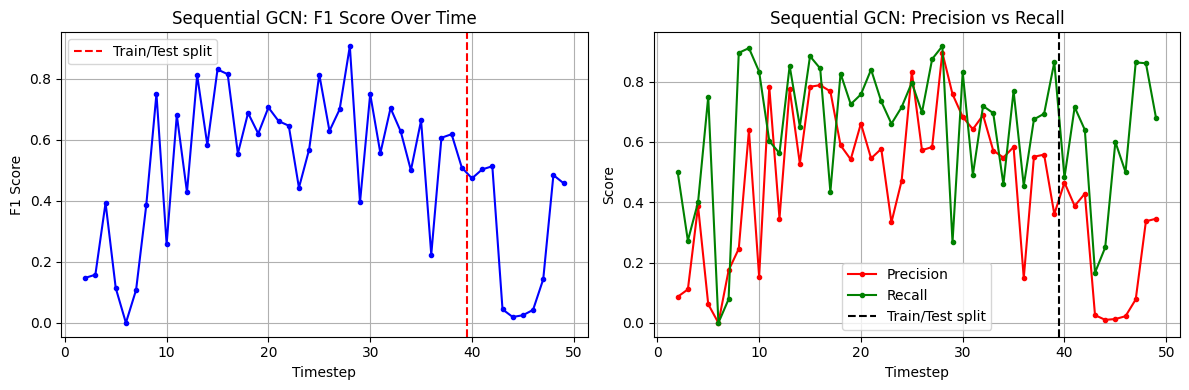

In [ ]:
# Plot F1 score over time
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# F1 over timesteps
axes[0].plot(results_df_seq['timestep'], results_df_seq['f1'], 'b-o', markersize=3)
axes[0].axvline(x=39.5, color='r', linestyle='--', label='Train/Test split')
axes[0].set_xlabel('Timestep')
axes[0].set_ylabel('F1 Score')
axes[0].set_title('Sequential GCN: F1 Score Over Time')
axes[0].legend()
axes[0].grid(True)

# Precision vs Recall
axes[1].plot(results_df_seq['timestep'], results_df_seq['precision'], 'r-o', markersize=3, label='Precision')
axes[1].plot(results_df_seq['timestep'], results_df_seq['recall'], 'g-o', markersize=3, label='Recall')
axes[1].axvline(x=39.5, color='k', linestyle='--', label='Train/Test split')
axes[1].set_xlabel('Timestep')
axes[1].set_ylabel('Score')
axes[1].set_title('Sequential GCN: Precision vs Recall')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()